In [1]:
# Import relevant items
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import lightgbm as lgb

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

from tqdm import tqdm

import seaborn as sns
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = [16,8]

Let's open the data

In [2]:
foo =r'C:\Users\ACER\Desktop\python project\airqo/BugolobiHOULY.csv'

In [3]:
df = pd.read_csv(foo, index_col=[0], parse_dates=[0])
df.sort_index(inplace = True)
print(df.index.is_monotonic)
print(df.info())

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 180 entries, 2019-03-12 09:00:00 to 2019-03-19 20:00:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   mean_pm2_5  179 non-null    float64
dtypes: float64(1)
memory usage: 2.8 KB
None


In [4]:
df

,mean_pm2_5
Date,
2019-03-12 09:00:00,20.362500
2019-03-12 10:00:00,NaN
2019-03-12 11:00:00,14.447857
2019-03-12 12:00:00,13.629348
2019-03-12 13:00:00,13.409565
...,...
2019-03-19 16:00:00,34.040000
2019-03-19 17:00:00,39.707000
2019-03-19 18:00:00,38.623152


We have 179 observations. There are no missing values.
from 2019-03-12 09:00:00 to 2019-03-19 20:00:00


# Resampling data for every  1 hour:

In [5]:
df = df.resample('1H').sum()

In [6]:
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 180 entries, 2019-03-12 09:00:00 to 2019-03-19 20:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   mean_pm2_5  180 non-null    float64
dtypes: float64(1)
memory usage: 2.8 KB
None


,mean_pm2_5
Date,
2019-03-12 09:00:00,20.362500
2019-03-12 10:00:00,0.000000
2019-03-12 11:00:00,14.447857
2019-03-12 12:00:00,13.629348
2019-03-12 13:00:00,13.409565
...,...
2019-03-19 16:00:00,34.040000
2019-03-19 17:00:00,39.707000
2019-03-19 18:00:00,38.623152


# Step 2. Analysis

Let's build a graph of the  entire study period OF March:

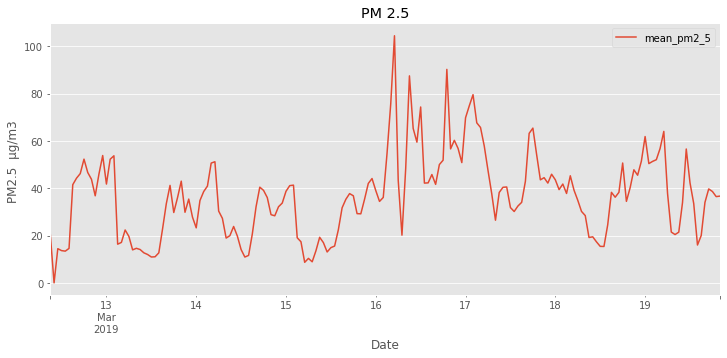

In [7]:
df.plot(figsize=(12,5));
plt.xlabel('Date')
plt.ylabel('PM2.5  µg/m3 ')
plt.title('PM 2.5')
plt.show()

 To analyze the daily trend,  resample the data for 1 day and build the corresponding graph. Also build a daily moving average chart:

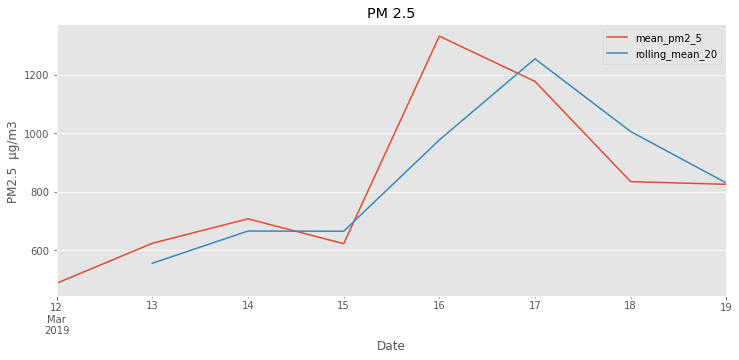

In [8]:
daily = df.resample('1D').sum()
daily['rolling_mean_20'] = df.resample('1D').sum().rolling(2).mean()
daily.plot(figsize=(12,5));
plt.xlabel('Date')
plt.ylabel('PM2.5  µg/m3 ')
plt.title('PM 2.5')
plt.show()

bserving a growing non-linear trend.

Let's go back to the hourly interval and plot the number of orders for the last DAY

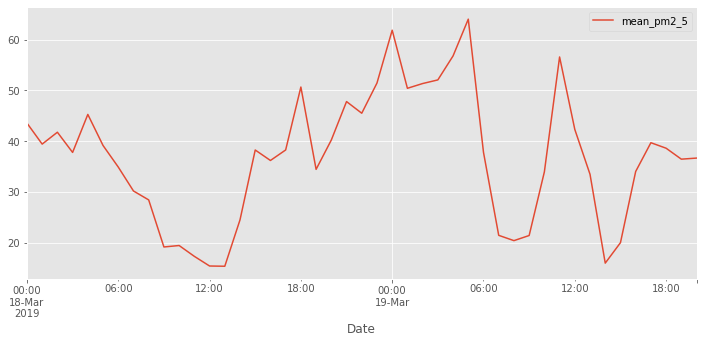

In [9]:
df['2019-03-18':'2019-03-20'].plot(figsize=(12,5));



 fluctuations are visible on the chart. Let us decompose the time series into trend and seasonality and build the corresponding charts:

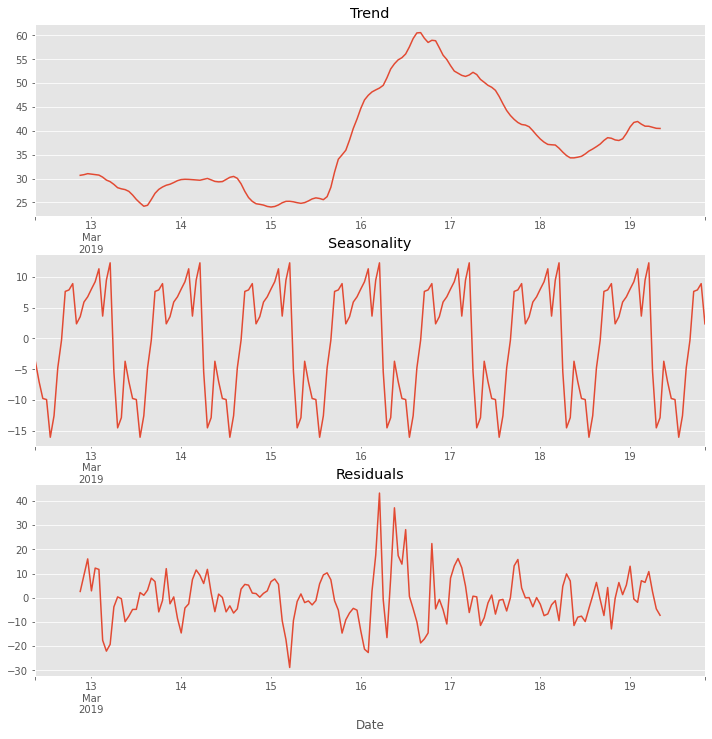

In [10]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(12, 12))
plt.subplot(311)
decomposed.trend['2019-03-12':'2019-03-19'].plot(ax=plt.gca())
plt.title('Trend');

plt.subplot(312)
decomposed.seasonal['2019-03-12':'2019-03-19'].plot(ax=plt.gca())
plt.title('Seasonality');

plt.subplot(313)
decomposed.resid['2019-03-12':'2019-03-19'].plot(ax=plt.gca())
plt.title('Residuals');

According to the seasonal graph, the frequency of cyclical changes in the time series is 1 day.

Let's build a graph of the trend obtained as a result of the decomposition for the entire study period. 

We will also build charts of the moving average of this trend for 2 and 24 HOURSs:

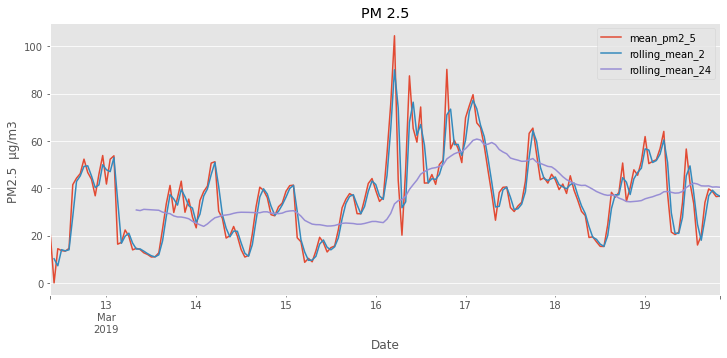

In [11]:
daily = df.resample('1H').sum()
daily['rolling_mean_2'] = df.resample('1H').sum().rolling(2).mean()
daily['rolling_mean_24'] = df.resample('1H').sum().rolling(12).mean()
daily['rolling_mean_24'] = df.resample('1H').sum().rolling(24).mean()
daily.plot(figsize=(12,5));
plt.xlabel('Date')
plt.ylabel('PM2.5  µg/m3 ')
plt.title('PM 2.5')
plt.show()

The trend FOR 24 hrs is not linear,but for 2 hours is close to it.

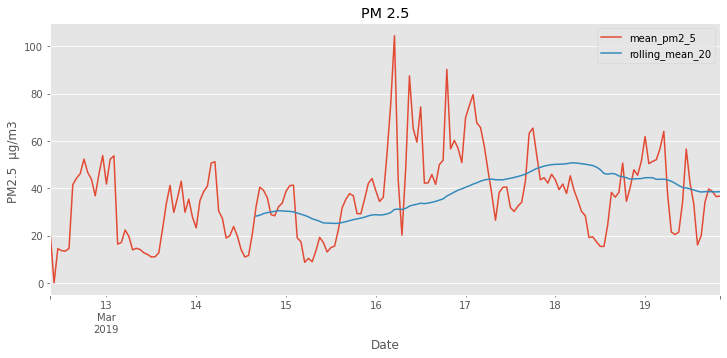

In [13]:
# for the next 26 hours
daily = df.resample('1H').sum()
daily['rolling_mean_20'] = df.resample('1H').sum().rolling(56).mean()
daily.plot(figsize=(12,5));
plt.xlabel('Date')
plt.ylabel('PM2.5  µg/m3 ')
plt.title('PM 2.5')
plt.show()

To improve the quality of the linear regression forecast, the logarithm the data in order to proceed to the study of linear dependencies:

In [14]:
df['num_orders_log'] = np.log(df['mean_pm2_5'].replace(0,0.1))

In [87]:
daily['rolling_mean_24'] = df.resample('1H').sum().rolling(24).mean()

ValueError: Wrong number of items passed 30, placement implies 1

Let us study the pairwise dependences of the hourly logarithmic number of orders among different days.

To do this, first, let's create a dataframe with the hourly logarithmic number of orders for each day:

In [18]:
df

,mean_pm2_5,num_orders_log
Date,,
2019-03-12 09:00:00,20.362500,3.013695
2019-03-12 10:00:00,0.000000,-2.302585
2019-03-12 11:00:00,14.447857,2.670546
2019-03-12 12:00:00,13.629348,2.612225
2019-03-12 13:00:00,13.409565,2.595968
...,...,...
2019-03-19 16:00:00,34.040000,3.527536
2019-03-19 17:00:00,39.707000,3.681527
2019-03-19 18:00:00,38.623152,3.653852


In [26]:
monthes = pd.DataFrame(index=df[('2019-3')].index).reset_index().drop('Date', axis=1).iloc[:720]

for day in df.index.day.unique():
    monthes['month_{}'.format(day)] = df[('2018-3-{}').format(day)]['num_orders_log'].iloc[:720].values
    
# limit ourselves to 30 days in each month so that the samples are the same size

<ipython-input-26-5602ecb7969c>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  monthes = pd.DataFrame(index=df[('2019-3')].index).reset_index().drop('Date', axis=1).iloc[:720]


KeyError: '2018-3-12'

Add columns with attributes to the original dataframe, including order hour, month day, day of the week. We will also add lags from 1 to 24 hours

In [29]:
def make_features(data, max_lag, rolling_mean_size):
    
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders_log'].shift(lag)

    for roll in rolling_mean_size:
        data['rolling_mean_{}'.format(roll)] = data['num_orders_log'].shift().rolling(roll).mean()

In [31]:
make_features(df, 24, [12 , 24])

# Step 3. Building models

In [75]:
from math import sqrt

Let's divide the data into training, validation and test samples. Let's standardize features.

In [32]:
train_valid, test = train_test_split(df, shuffle=False, test_size=0.1)
train, valid = train_test_split(train_valid, shuffle=False, test_size=test.shape[0])



In [34]:
train = train.dropna()

scaler = StandardScaler()
scaler.fit(train.drop(['mean_pm2_5', 'num_orders_log'], axis=1))

StandardScaler()

In [35]:
X_train = pd.DataFrame(scaler.transform(train.drop(['mean_pm2_5', 'num_orders_log'], axis=1)),\
                       index=train.drop(['mean_pm2_5', 'num_orders_log'], axis=1).index,\
                       columns=train.drop(['mean_pm2_5', 'num_orders_log'], axis=1).columns)

X_valid = pd.DataFrame(scaler.transform(valid.drop(['mean_pm2_5', 'num_orders_log'], axis=1)),\
                       index=valid.drop(['mean_pm2_5', 'num_orders_log'], axis=1).index,\
                       columns=valid.drop(['mean_pm2_5', 'num_orders_log'], axis=1).columns)

X_test = pd.DataFrame(scaler.transform(test.drop(['mean_pm2_5', 'num_orders_log'], axis=1)),\
                       index=test.drop(['mean_pm2_5', 'num_orders_log'], axis=1).index,\
                       columns=test.drop(['mean_pm2_5', 'num_orders_log'], axis=1).columns)

y_train = train['mean_pm2_5']
y_train_log = train['num_orders_log']

y_valid = valid['mean_pm2_5']
y_valid_log = valid['num_orders_log']

y_test = test['mean_pm2_5']
y_test_log = test['num_orders_log']

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(120, 28)
(18, 28)
(18, 28)


First, let's calculate the quality metrics of the base (initial) models:

In [36]:
pred_mean = np.ones(y_test.shape) * y_train.mean()
print("RMSE:", mean_squared_error(y_test, pred_mean)**.5)

RMSE: 13.570891760971836


The model that returns the average number of orders has an average error of 13.5708 orders.

In [37]:
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_valid.iloc[-1]

print("RMSE:", mean_squared_error(y_test, pred_previous)**.5)

RMSE: 11.878971114073787


# GaussianProcessRegressor

In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn import model_selection

# Create MLPRegressor object
gpr = GaussianProcessRegressor()

In [57]:
# Train the model using the training sets
gpr.fit(X_train, y_train)

GaussianProcessRegressor()

In [58]:
# Score the model
GP_regression_score = gpr.score(X_test, y_test)
GP_regression_score

-7.330990515180389

In [59]:
# Make predictions using the testing set
gpr_pred = gpr.predict(X_test)

In [85]:
# The mean squared error
print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, gpr_pred)))
# The absolute squared error
print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, gpr_pred))
# Explained variance score: 1 is perfect prediction
print('R-squared: %.2f' % r2_score(y_test, gpr_pred))

Root mean squared error: 39.03
Mean absolute error: 36.56
R-squared: -7.33


# LinearRegression

In [38]:
lr = LinearRegression()
lr.fit(X_train, (y_train_log))

lr_pred_train = np.exp(lr.predict(X_train))
lr_pred_valid = np.exp(lr.predict(X_valid))

rmse_train = mean_squared_error(y_train, lr_pred_train)**.5
rmse_valid = mean_squared_error(y_valid, lr_pred_valid)**.5

print('RMSE the training sample:', rmse_train)
print('RMSE the validation set:', rmse_valid)

RMSE the training sample: 10.235996272315575
RMSE the validation set: 8.369390744878048


RMSE on the validation set 8.36939,

In [39]:
lasso = LassoCV().fit(X_train, y_train_log)

importance = np.abs(lasso.coef_)
idx_features = np.nonzero(importance)
name_features = np.array(X_train.columns.tolist())[idx_features]
print(name_features)
print(len(name_features))

['hour' 'day' 'lag_1' 'lag_2' 'lag_5' 'lag_6' 'lag_8' 'lag_10' 'lag_12'
 'lag_14' 'lag_23' 'lag_24']
12


Let's construct new predictions.

In [40]:
lasso_pred_train = np.exp(lasso.predict(X_train))
lasso_pred_valid = np.exp(lasso.predict(X_valid))

rmse_train = mean_squared_error(y_train, lasso_pred_train)**.5
rmse_valid = mean_squared_error(y_valid, lasso_pred_valid)**.5


print('RMSE the training sample:', rmse_train)
print('RMSE the validation set:', rmse_valid)

RMSE the training sample: 10.754621580160354
RMSE the validation set: 7.572125821181239


In [41]:
fr1 = RandomForestRegressor(n_estimators=20, random_state=12345)
fr1.fit(X_train[name_features], y_train_log)

fr1_pred_train = np.exp(fr1.predict(X_train[name_features]))
fr1_pred_valid = np.exp(fr1.predict(X_valid[name_features]))

rmse_train = mean_squared_error(y_train, fr1_pred_train)**.5
rmse_valid = mean_squared_error(y_valid, fr1_pred_valid)**.5

print('RMSE the training sample:', rmse_train)
print('RMSE the validation set:', rmse_valid)

RMSE the training sample: 4.431942790016216
RMSE the validation set: 8.052864680783175


To improve the quality of the model (reduce overfitting), we will iterate over different values ​​of the maximum tree depth and minimum sample size for further division:

In [42]:
param_grid = dict(min_samples_split=range(2,20), max_depth=range(10,30))
param_grid

{'min_samples_split': range(2, 20), 'max_depth': range(10, 30)}

In [43]:
rmse_best = 30
best_depth = 0
best_min_split = 0

for params in tqdm(ParameterGrid(param_grid)):

    fr = RandomForestRegressor(n_estimators = 20,
                                min_samples_split = params['min_samples_split'],
                                max_depth = params['max_depth'],
                                random_state=12345)

    fr.fit(X_train[name_features], y_train_log)
    fr_pred_valid = np.exp(fr.predict(X_valid[name_features]))
    
    rmse = mean_squared_error(y_valid, fr_pred_valid)**.5
    
    if rmse < rmse_best:
        rmse_best = rmse
        best_depth = params['max_depth']
        best_min_split = params['min_samples_split']

100%|████████████████████████████████████████████████████████████████████████████████| 360/360 [00:23<00:00, 15.16it/s]


In [44]:
print('Best RMSE on a validation set :', rmse_best)
print('Best depth:', best_depth)
print('Best minimum sample size for splitting:', best_min_split)

Best RMSE on a validation set : 7.97299553793517
Best depth: 14
Best minimum sample size for splitting: 2


# Random Forest Regressor

Let's increase the number of trees in the ensemble:

In [46]:
for est in tqdm([100, 150, 200, 250, 300]):
    
    fr = RandomForestRegressor(n_estimators = est,
                               max_depth = 11,
                               min_samples_split = 6,
                               random_state = 12345)
    
    fr.fit(X_train[name_features], y_train_log)
    fr_pred_valid = np.exp(fr.predict(X_valid[name_features]))
    rmse = mean_squared_error(y_valid, fr_pred_valid)**.5
    
    print('RMSE:', rmse, 'Number of trees:', est)

 20%|████████████████▊                                                                   | 1/5 [00:00<00:01,  3.22it/s]

RMSE: 7.8518012491551135 Number of trees: 100


 40%|█████████████████████████████████▌                                                  | 2/5 [00:00<00:01,  2.82it/s]

RMSE: 7.684105847969758 Number of trees: 150


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:01<00:00,  2.17it/s]

RMSE: 7.719748317594764 Number of trees: 200


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:01<00:00,  1.85it/s]

RMSE: 7.643295470354346 Number of trees: 250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]

RMSE: 7.613294905826584 Number of trees: 300


In [47]:
for est in tqdm([10, 15, 20, 25, 30]):
    
    fr = RandomForestRegressor(n_estimators = est,
                               max_depth = 11,
                               min_samples_split = 6,
                               random_state = 12345)
    
    fr.fit(X_train[name_features], y_train_log)
    fr_pred_valid = np.exp(fr.predict(X_valid[name_features]))
    rmse = mean_squared_error(y_valid, fr_pred_valid)**.5
    
    print('RMSE:', rmse, 'Number of trees:', est)

 40%|█████████████████████████████████▌                                                  | 2/5 [00:00<00:00, 14.40it/s]

RMSE: 8.954041544822964 Number of trees: 10
RMSE: 8.754790404720117 Number of trees: 15
RMSE: 8.631408169416964 Number of trees: 20


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.13it/s]

RMSE: 8.277478321846841 Number of trees: 25
RMSE: 7.8105445339003445 Number of trees: 30


# gradient boosting model:

In [48]:
lgb_train = lgb.Dataset(X_train[name_features], y_train_log)
lgb_eval = lgb.Dataset(X_valid[name_features], y_valid_log, reference=lgb_train)

params1 = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'verbose': 0
}

gbm1 = lgb.train(params1,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                early_stopping_rounds=20)

y_pred_valid1 = np.exp(gbm1.predict(X_valid[name_features], num_iteration=gbm1.best_iteration))

print()
print('RMSE models on a validation set:', mean_squared_error(y_valid, y_pred_valid1)**.5)
print()

C:\Users\ACER\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 0.409388
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 0.372399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 0.339857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 0.314571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 0.292798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 0.275709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0

In [86]:
print('RMSE test sample​: ', mean_squared_error(y_test, np.exp(lasso.predict(X_test)))**.5)

RMSE test sample​:  10.338594843988265


# ExtraTreesRegressor

In [51]:
from sklearn.ensemble import ExtraTreesRegressor

extra_tree = ExtraTreesRegressor(n_estimators=200, random_state=1234)

In [52]:
extra_tree.fit(X_train, y_train)

ExtraTreesRegressor(n_estimators=200, random_state=1234)

In [53]:
extratree_score = extra_tree.score(X_test, y_test)
extratree_score

0.3036333728742818

In [54]:
extratree_pred = extra_tree.predict(X_test)

In [77]:
print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, extratree_pred)))

Root mean squared error: 11.28


# XGBoost

In [61]:
from xgboost.sklearn import XGBRegressor

#Fitting XGB regressor 
xboost = XGBRegressor(n_estimators=200)

In [62]:
xboost.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [63]:
xgb_score = xboost.score(X_test, y_test)
xgb_score

0.05667560131863181

In [64]:
xgb_score = xboost.score(X_test, y_test)
xgb_score

0.05667560131863181

# Decision Tree + AdaBoost

In [65]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create Decision Tree Regressor object
tree_1 = DecisionTreeRegressor()

tree_2 = AdaBoostRegressor(DecisionTreeRegressor(), n_estimators=200, learning_rate=.1)

In [67]:
# Train the model using the training sets
tree_1.fit(X_train, y_train)
tree_2.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), learning_rate=0.1,
                  n_estimators=200)

In [68]:
# Make predictions using the testing set
tree_1_pred = tree_1.predict(X_test)
tree_2_pred = tree_2.predict(X_test)

In [69]:
# Score the decision tree model
tree_1.score(X_test, y_test)

-0.78013506185474

In [70]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Create Random Forrest Regressor object
regr_rf = RandomForestRegressor(n_estimators=200, random_state=1234)

In [71]:
# Train the model using the training sets
regr_rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=1234)

In [72]:
# Score the model
decision_forest_score = regr_rf.score(X_test, y_test)
decision_forest_score

0.1210840770299848

In [73]:
# Make predictions using the testing set
regr_rf_pred = regr_rf.predict(X_test)

In [76]:
# The mean squared error
print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, regr_rf_pred)))
# The absolute squared error
print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, regr_rf_pred))
# Explained variance score: 1 is perfect prediction
print('R-squared: %.2f' % r2_score(y_test, regr_rf_pred))

Root mean squared error: 12.68
Mean absolute error: 9.90
R-squared: 0.12


In [ ]:
df[[]]

In [79]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create MLPRegressor object
#mlp = GaussianProcessRegressor()
mlp = MLPRegressor()

In [80]:
mlp.fit(X_train, y_train)

C:\Users\ACER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor()

In [81]:
# Score the model
neural_network_regression_score = mlp.score(X_test, y_test)
neural_network_regression_score

-0.9500144879759731

In [83]:
# Make predictions using the testing set
nnr_pred = mlp.predict(X_test)

In [84]:
# The mean squared error
print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, nnr_pred)))
# The absolute squared error
print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, nnr_pred))
# Explained variance score: 1 is perfect prediction
print('R-squared: %.2f' % r2_score(y_test, nnr_pred))

Root mean squared error: 18.88
Mean absolute error: 15.59
R-squared: -0.95
